# Video Games Recommendation System

Import modules

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from fuzzywuzzy import process
from spellchecker import SpellChecker

warnings.filterwarnings("ignore")

C:\Users\Acer\AppData\Roaming\Python\Python312\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


Import dataset

In [9]:
video_game_df = pd.read_csv('video_game_dataset.csv')
video_game_df.head()

,Name,Platform,Publisher,Genre,Metascore,User_Score,Release_Year
0,Senua's Saga: Hellblade II,Xbox,Xbox,Action,81.0,7.5,2024.0
1,Zet Zillion,PC,Raw Fury,Card,79.0,8.8,2024.0
2,Duck Detective: The Secret Salami,PC,Happy Broccoli Games,Adventure,81.0,6.8,2024.0
3,Rakugaki,PC,Gearbox Publishing,Action,79.0,7.2,2024.0
4,Elden Ring,PS5,Bandai Namco Games,Action,96.0,8.8,2022.0


# Preprocessing

Missing value

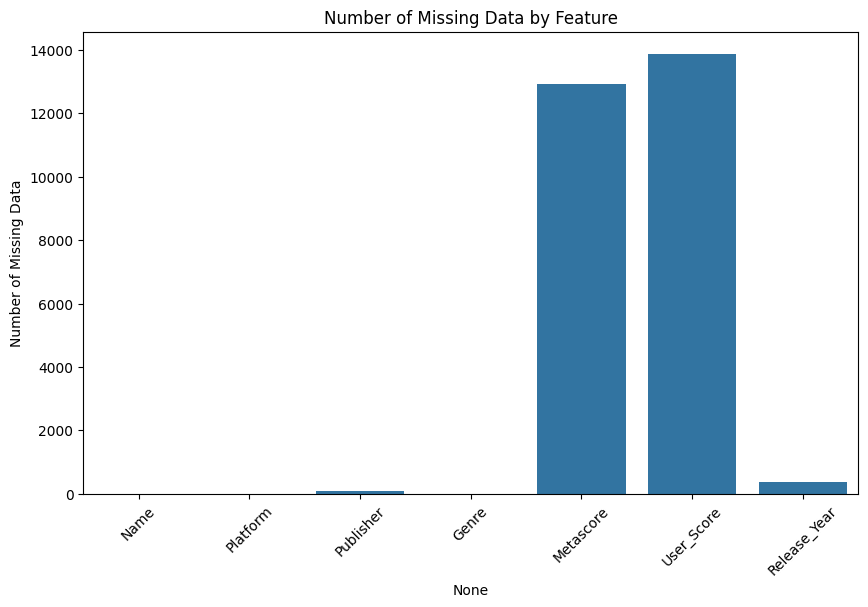

User_Score      13882
Metascore       12921
Release_Year      380
Publisher          78
Name                3
Genre               3
Platform            0
dtype: int64


In [10]:
missing_data_counts = video_game_df.isnull().sum()

plt.figure(figsize=(10, 6))
sns.barplot(x=missing_data_counts.index, y=missing_data_counts.values)
plt.title('Number of Missing Data by Feature')
plt.ylabel('Number of Missing Data')
plt.xticks(rotation=45)
plt.show()

print(missing_data_counts.sort_values(ascending=False))

Duplicate value

In [11]:
duplicates = video_game_df[video_game_df.duplicated()]

print(duplicates)

                                                   Name Platform  \
149                                     EA Sports FC 24      PS5   
150                      Tom Clancy's Rainbow Six Siege       PC   
151                                            Valorant       PC   
152                    Counter-Strike: Global Offensive       PC   
153                                    Counter-Strike 2       PC   
...                                                 ...      ...   
23706  SCORE International Baja 1000: The Official Game      PS2   
23707                     Samurai Warriors: Sanada Maru      PS3   
23708                                  LMA Manager 2007     X360   
23709                           Haitaka no Psychedelica      PSV   
23710                                  Spirits & Spells      GBA   

             Publisher      Genre  Metascore  User_Score  Release_Year  
149    Electronic Arts      Sport       75.0         2.3        2023.0  
150            Ubisoft        FPS    

Fix dataset

In [12]:
video_game_df.drop_duplicates(inplace=True)
video_game_df.dropna(axis=0, inplace=True)
video_game_df = video_game_df.reset_index(drop=True)

video_game_df.isna().sum()
video_game_df.shape

(7044, 7)

In [13]:
video_game_df

,Name,Platform,Publisher,Genre,Metascore,User_Score,Release_Year
0,Senua's Saga: Hellblade II,Xbox,Xbox,Action,81.0,7.5,2024.0
1,Zet Zillion,PC,Raw Fury,Card,79.0,8.8,2024.0
2,Duck Detective: The Secret Salami,PC,Happy Broccoli Games,Adventure,81.0,6.8,2024.0
3,Rakugaki,PC,Gearbox Publishing,Action,79.0,7.2,2024.0
4,Elden Ring,PS5,Bandai Namco Games,Action,96.0,8.8,2022.0
...,...,...,...,...,...,...,...
7039,SÃƒÂ©bastien Loeb Rally Evo,PS4,Milestone S.r.l,Racing,71.0,8.1,2016.0
7040,Red FAction II,GC,THQ,Shooter,79.0,7.3,2003.0
7041,Red FAction: Guerrilla,PC,THQ,Shooter,82.0,7.5,2009.0
7042,Guild Wars: FActions,PC,NCSoft,Role-Playing,84.0,8.5,2006.0


# Data Distribution

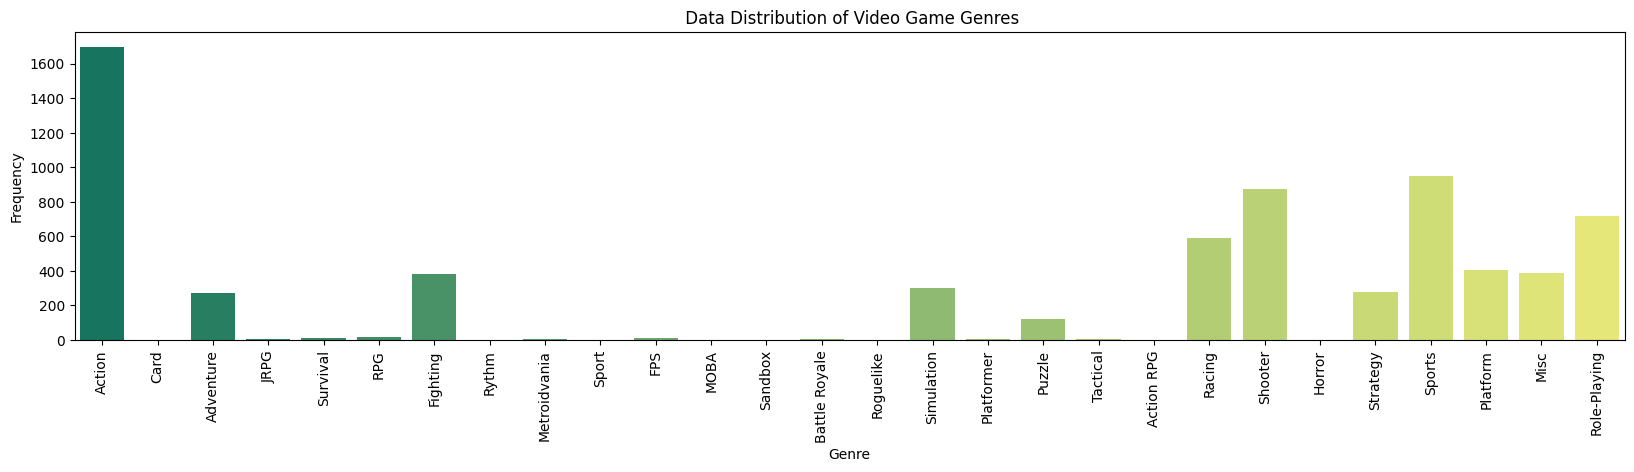

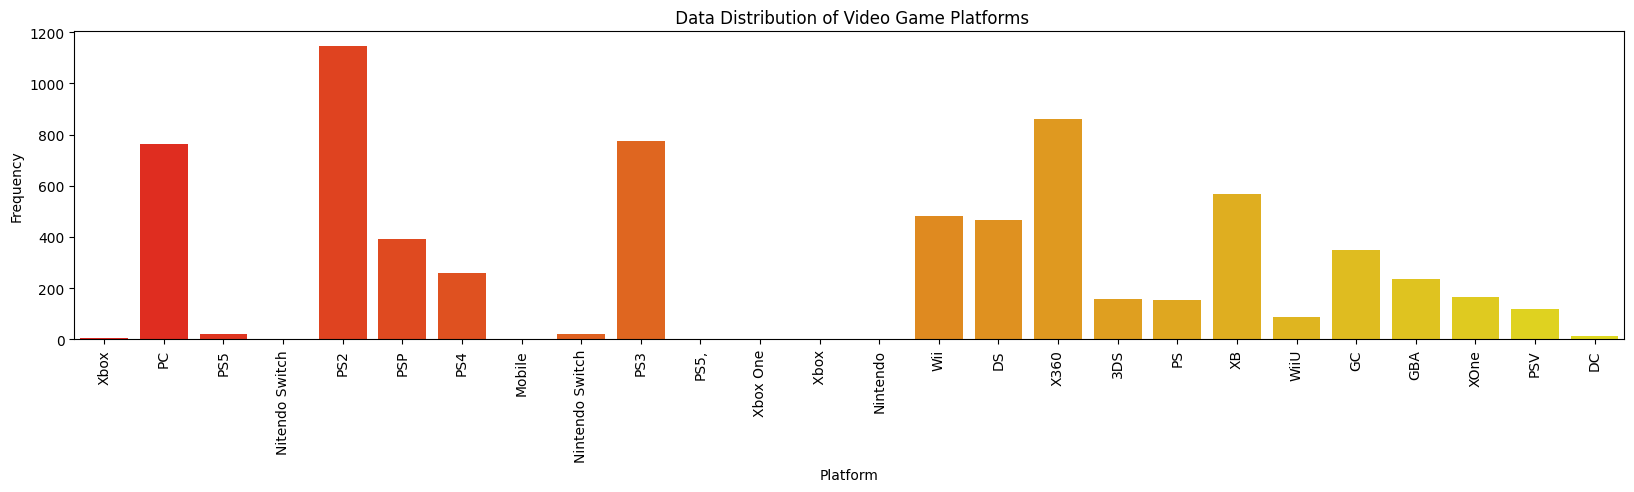

In [14]:
features = video_game_df[['Genre', 'Platform']].columns
palettes = ['summer', 'autumn']

for idx, feature in enumerate(features):
    plt.figure(figsize = (20,4))
    sns.countplot(data=video_game_df, x=feature, palette=palettes[idx])
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.title(" Data Distribution of Video Game " + feature + "s")
    plt.xticks(rotation=90)
plt.show()

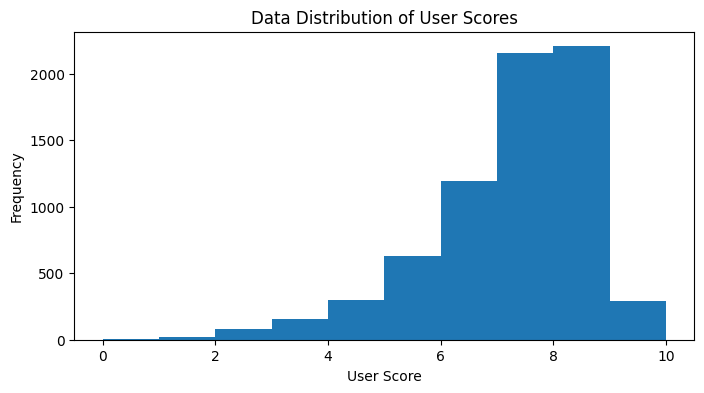

In [15]:
hist, bins = np.histogram(video_game_df['User_Score'], bins=10, range=(0, 10))

plt.figure(figsize = (8,4))
plt.bar(bins[:-1], hist, width=(bins[1]-bins[0]), align='edge')
plt.xlabel('User Score')
plt.ylabel('Frequency')
plt.title("Data Distribution of User Scores")
plt.show()

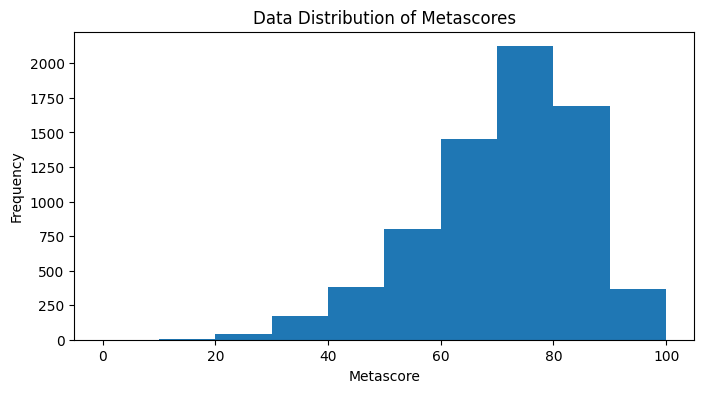

In [16]:
hist, bins = np.histogram(video_game_df['Metascore'], bins=10, range=(0, 100))

plt.figure(figsize = (8,4))
plt.bar(bins[:-1], hist, width=(bins[1]-bins[0]), align='edge')
plt.xlabel('Metascore')
plt.ylabel('Frequency')
plt.title("Data Distribution of Metascores")
plt.show()

[Text(0.5, 0, 'User Score'),
 Text(0, 0.5, 'Critic Score'),
 Text(0.5, 1.0, 'User Scores vs. Metascores')]

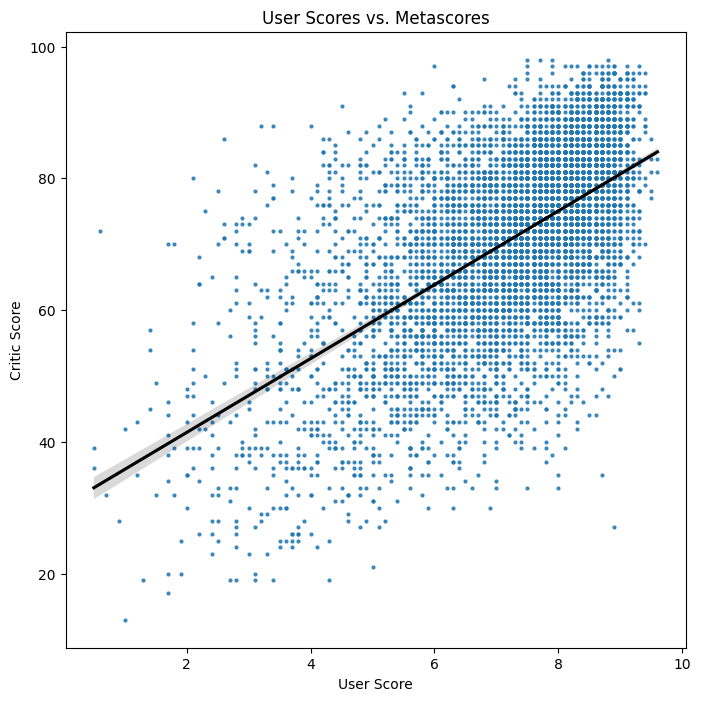

In [17]:
plt.figure(figsize=(8, 8))
ax = sns.regplot(x=video_game_df['User_Score'], y=video_game_df['Metascore'], 
                 line_kws={"color": "black"}, scatter_kws={'s': 4})
ax.set(xlabel ="User Score", ylabel = "Critic Score", title="User Scores vs. Metascores")

# Model

Converting Categorical Features to Dummy Indicators:
Obtain all categorical features, except for the title of the game.

In [18]:
categorical_columns = [name for name in video_game_df.columns if video_game_df[name].dtype=='O']
categorical_columns = categorical_columns[1:]

print(f'There are {len(categorical_columns)} categorical features:\n')
print(", ".join(categorical_columns))

There are 3 categorical features:

Platform, Publisher, Genre


Transform all categorical attributes into binary dummy variables where the value is False or True.

In [19]:
video_games_df_dummy = pd.get_dummies(data=video_game_df, columns=categorical_columns)
video_games_df_dummy.head(5)

,Name,Metascore,User_Score,Release_Year,Platform_ Xbox,Platform_3DS,Platform_DC,Platform_DS,Platform_GBA,Platform_GC,...,Genre_Role-Playing,Genre_Rythm,Genre_Sandbox,Genre_Shooter,Genre_Simulation,Genre_Sport,Genre_Sports,Genre_Strategy,Genre_Survival,Genre_Tactical
0,Senua's Saga: Hellblade II,81.0,7.5,2024.0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,Zet Zillion,79.0,8.8,2024.0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,Duck Detective: The Secret Salami,81.0,6.8,2024.0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,Rakugaki,79.0,7.2,2024.0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,Elden Ring,96.0,8.8,2022.0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


Standardizing the Numerical Features: 
Transform numerical data to a standardized form by scaling them to have a mean of 0 and a standard deviation of 1. The purpose of standardization is to ensure that all features are on a similar scale and have equal importance in determining the output variable.

In [20]:
features_dummy = video_games_df_dummy.drop(columns=['Name'], axis=1)

scale = StandardScaler()
scaled_features = scale.fit_transform(features_dummy)
scaled_features = pd.DataFrame(scaled_features, columns=features_dummy.columns)

scaled_features.head(5)

,Metascore,User_Score,Release_Year,Platform_ Xbox,Platform_3DS,Platform_DC,Platform_DS,Platform_GBA,Platform_GC,Platform_Mobile,...,Genre_Role-Playing,Genre_Rythm,Genre_Sandbox,Genre_Shooter,Genre_Simulation,Genre_Sport,Genre_Sports,Genre_Strategy,Genre_Survival,Genre_Tactical
0,0.751179,0.210426,3.583417,-0.011916,-0.150493,-0.044626,-0.265856,-0.186593,-0.228317,-0.016853,...,-0.336375,-0.011916,-0.016853,-0.375877,-0.212011,-0.016853,-0.39483,-0.20308,-0.035768,-0.020642
1,0.607353,1.114530,3.583417,-0.011916,-0.150493,-0.044626,-0.265856,-0.186593,-0.228317,-0.016853,...,-0.336375,-0.011916,-0.016853,-0.375877,-0.212011,-0.016853,-0.39483,-0.20308,-0.035768,-0.020642
2,0.751179,-0.276399,3.583417,-0.011916,-0.150493,-0.044626,-0.265856,-0.186593,-0.228317,-0.016853,...,-0.336375,-0.011916,-0.016853,-0.375877,-0.212011,-0.016853,-0.39483,-0.20308,-0.035768,-0.020642
3,0.607353,0.001787,3.583417,-0.011916,-0.150493,-0.044626,-0.265856,-0.186593,-0.228317,-0.016853,...,-0.336375,-0.011916,-0.016853,-0.375877,-0.212011,-0.016853,-0.39483,-0.20308,-0.035768,-0.020642
4,1.829878,1.114530,3.143234,-0.011916,-0.150493,-0.044626,-0.265856,-0.186593,-0.228317,-0.016853,...,-0.336375,-0.011916,-0.016853,-0.375877,-0.212011,-0.016853,-0.39483,-0.20308,-0.035768,-0.020642


The machine learning algorithm NearestNeighbors will be utilized to identify the data points nearest to a given input, with the aid of the cosine similarity measurement to determine the similarity or dissimilarity between data points.

As we included n_neighbors=1 as a parameter for our model, it will generate 11 indices and distances of games that are similar to the user input, including the input itself.

In [21]:
nn_model = NearestNeighbors(n_neighbors=11, metric='cosine', algorithm='brute').fit(scaled_features)
print(nn_model)

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=11)


In [22]:
vg_distances, vg_indices = nn_model.kneighbors(scaled_features)

print("List of indexes and distances for the first 5 games:\n")
print(vg_indices[:5], "\n")
print(vg_distances[:5])

List of indexes and distances for the first 5 games:

[[   0  124  125  119  123   78   64  139 6995    7 5806]
 [   1   78   64  139 5762 3093 6290 6769 6995 6597 5806]
 [   2 5208 6465 3875 5179 6377 6772 6863 2608 2280 7012]
 [   3   78   64 6995  139 3010 6853 5806 6597 4654 4173]
 [   4  118  100  101   99   74   97  127  103  138   90]] 

[[0.00000000e+00 3.16031201e-01 4.92328767e-01 6.77456977e-01
  7.40733504e-01 9.67059434e-01 9.72477693e-01 9.73308561e-01
  9.78140667e-01 9.78300194e-01 9.80146353e-01]
 [1.11022302e-16 9.71162433e-01 9.75339013e-01 9.76726598e-01
  9.76858533e-01 9.77238134e-01 9.77405486e-01 9.79179104e-01
  9.79445434e-01 9.79736921e-01 9.79788020e-01]
 [1.88737914e-15 9.34397365e-01 9.43484976e-01 9.44150705e-01
  9.47585337e-01 9.48045129e-01 9.48489222e-01 9.48843322e-01
  9.52593229e-01 9.52920948e-01 9.54502876e-01]
 [0.00000000e+00 9.50660013e-01 9.56660598e-01 9.59308862e-01
  9.59609422e-01 9.59838268e-01 9.60743912e-01 9.60759675e-01
  9.60891812e

TfidfVectorizer is a feature extraction method commonly used in natural language processing and information retrieval tasks. In this case, it is used to suggest a video game title based on the user input (i.e. game that doesn't exist in the records) by evaluating the importance of words in the input relative to the existing records.

In [23]:
game_names = video_games_df_dummy['Name'].drop_duplicates()
game_names = game_names.reset_index(drop=True)

vectorizer = TfidfVectorizer(use_idf=True).fit(game_names)
print(vectorizer)

TfidfVectorizer()


In [24]:
game_title_vectors = vectorizer.transform(game_names)

print("List of game title vectors for the first 5 games:\n")
print(pd.DataFrame(game_title_vectors.toarray()).head(5))

List of game title vectors for the first 5 games:

   0     1     2     3     4     5     6     7     8     9     ...  3892  \
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
1   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
2   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
3   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
4   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   

   3893  3894  3895  3896  3897  3898  3899  3900  3901  
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
1   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
3   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
4   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[5 rows x 3902 columns]


The program utilizes the above-mentioned model to provide video game recommendations to users. It will ask user to enter the game's name and, optionally, the platform to filter the results. The list of recommended games will be arranged in ascending order based on the calculated distances. On the other hand, if the game's name is not in the record, the program will suggest a new name of the game that has the closest match to the input.

In [25]:
def VideoGameTitleRecommender(video_game_name):
    '''
    This function will recommend a game title that has the closest match to the input
    '''
    query_vector = vectorizer.transform([video_game_name])
    similarity_scores = cosine_similarity(query_vector, game_title_vectors)

    closest_match_index = similarity_scores.argmax()
    closest_match_game_name = game_names[closest_match_index]
    
   
    spell = SpellChecker(language='en')
    words = video_game_name.split()
    corrected_words = [spell.correction(word) for word in words]
    corrected_game_name = ' '.join(corrected_words)
    closest_match_game_name = process.extractOne(corrected_game_name, game_names)[0]

    return closest_match_game_name

def VideoGameRecommender_Genre(video_game_name, video_game_genre='Any'):
    '''
    This function will provide game recommendations based on various features of the game
    '''
    default_genre = 'Any'

    # User input: Game Title and Genre
    if video_game_genre != default_genre:
        video_game_idx = video_game_df.query("Name == @video_game_name & Genre == @video_game_genre").index
        
        if video_game_idx.empty:
            video_game_idx = video_game_df.query("Name == @video_game_name").index

            if not video_game_idx.empty:
                print(f"Note: Recommendations will be based on the title of the game as it is not available in the specified genre.\n")
                video_game_genre = default_genre
    
    # User input: Game Title only
    else:
        video_game_idx = video_game_df.query("Name == @video_game_name").index  
    
    if video_game_idx.empty:
        # If the game entered by the user doesn't exist in the records, the program will recommend a new game similar to the input
        closest_match_game_name = VideoGameTitleRecommender(video_game_name)

        print(f"'{video_game_name}' doesn't exist in the records.\n")
        print(f"You may want to try '{closest_match_game_name}', which is the closest match to the input.")
    
    else:
        # User input: Game Title only
        if video_game_genre == default_genre:

            # Place in a separate dataframe the indices and distances, then sort the record by distance in ascending order       
            vg_combined_dist_idx_df = pd.DataFrame()
            for idx in video_game_idx:
                # Remove from the list any game that shares the same name as the input
                vg_dist_idx_df = pd.concat([pd.DataFrame(vg_indices[idx][1:]), pd.DataFrame(vg_distances[idx][1:])], axis=1)
                vg_combined_dist_idx_df = pd.concat([vg_combined_dist_idx_df, vg_dist_idx_df])

            vg_combined_dist_idx_df = vg_combined_dist_idx_df.set_axis(['Index', 'Distance'], axis=1)
            vg_combined_dist_idx_df = vg_combined_dist_idx_df.reset_index(drop=True)
            vg_combined_dist_idx_df = vg_combined_dist_idx_df.sort_values(by='Distance', ascending=True)

            video_game_list = video_game_df.iloc[vg_combined_dist_idx_df['Index']]

            # Remove any duplicate game names to provide the user with a diverse selection of recommended games
            video_game_list = video_game_list.drop_duplicates(subset=['Name'], keep='first')
            
            # Get the first 10 games in the list
            video_game_list = video_game_list.head(10)

            # Get the distance of the games similar to the input
            recommended_distances = np.array(vg_combined_dist_idx_df['Distance'].head(10))

        # User input: Game Title and Genre
        else:
            # Remove from the list any game that shares the same name as the input
            recommended_idx = vg_indices[video_game_idx[0]][1:]
            video_game_list = video_game_df.iloc[recommended_idx]

            # Filter out games of other genres
            video_game_list = video_game_list[video_game_list['Genre'] == video_game_genre]

            # Get the distance of the games similar to the input
            recommended_distances = np.array(vg_distances[video_game_idx[0]][1:])

        print(f"Top 10 Recommended Video Games for '{video_game_name}' [genre:{video_game_genre}]")

        video_game_list = video_game_list.reset_index(drop=True)
        recommended_video_game_list = pd.concat([video_game_list, 
                                                 pd.DataFrame(recommended_distances, columns=['Similarity_Distance'])], axis=1)
        
        recommended_video_game_list['Metascore'].fillna(0, inplace=True)
        recommended_video_game_list['Release_Year'].fillna(0, inplace=True)

        # Convert Metascore and Release Year to integer type
        recommended_video_game_list['Metascore'] = recommended_video_game_list['Metascore'].astype(int)
        recommended_video_game_list['Release_Year'] = recommended_video_game_list['Release_Year'].astype(int)

        display(recommended_video_game_list.style.hide(axis=0))


def VideoGameRecommender_Platform(video_game_name, video_game_platform='Any'):
    '''
    This function will provide game recommendations based on various features of the game
    '''
    default_platform = 'Any'

    # User input: Game Title and Genre
    if video_game_platform != default_platform:
        video_game_idx = video_game_df.query("Name == @video_game_name & Platform == @video_game_platform").index
        
        if video_game_idx.empty:
            video_game_idx = video_game_df.query("Name == @video_game_name").index

            if not video_game_idx.empty:
                print(f"Note: Recommendations will be based on the title of the game as it is not available in the specified genre.\n")
                video_game_platform = default_platform
    
    # User input: Game Title only
    else:
        video_game_idx = video_game_df.query("Name == @video_game_name").index  
    
    if video_game_idx.empty:
        # If the game entered by the user doesn't exist in the records, the program will recommend a new game similar to the input
        closest_match_game_name = VideoGameTitleRecommender(video_game_name)

        print(f"'{video_game_name}' doesn't exist in the records.\n")
        print(f"You may want to try '{closest_match_game_name}', which is the closest match to the input.")
    
    else:
        # User input: Game Title only
        if video_game_platform == default_platform:

            # Place in a separate dataframe the indices and distances, then sort the record by distance in ascending order       
            vg_combined_dist_idx_df = pd.DataFrame()
            for idx in video_game_idx:
                # Remove from the list any game that shares the same name as the input
                vg_dist_idx_df = pd.concat([pd.DataFrame(vg_indices[idx][1:]), pd.DataFrame(vg_distances[idx][1:])], axis=1)
                vg_combined_dist_idx_df = pd.concat([vg_combined_dist_idx_df, vg_dist_idx_df])

            vg_combined_dist_idx_df = vg_combined_dist_idx_df.set_axis(['Index', 'Distance'], axis=1)
            vg_combined_dist_idx_df = vg_combined_dist_idx_df.reset_index(drop=True)
            vg_combined_dist_idx_df = vg_combined_dist_idx_df.sort_values(by='Distance', ascending=True)

            video_game_list = video_game_df.iloc[vg_combined_dist_idx_df['Index']]

            # Remove any duplicate game names to provide the user with a diverse selection of recommended games
            video_game_list = video_game_list.drop_duplicates(subset=['Name'], keep='first')
            
            # Get the first 10 games in the list
            video_game_list = video_game_list.head(10)

            # Get the distance of the games similar to the input
            recommended_distances = np.array(vg_combined_dist_idx_df['Distance'].head(10))

        # User input: Game Title and Genre
        else:
            # Remove from the list any game that shares the same name as the input
            recommended_idx = vg_indices[video_game_idx[0]][1:]
            video_game_list = video_game_df.iloc[recommended_idx]

            # Filter out games of other genres
            video_game_list = video_game_list[video_game_list['Platform'] == video_game_platform]

            # Get the distance of the games similar to the input
            recommended_distances = np.array(vg_distances[video_game_idx[0]][1:])

        print(f"Top 10 Recommended Video Games for '{video_game_name}' [platform:{video_game_platform}]")

        video_game_list = video_game_list.reset_index(drop=True)
        recommended_video_game_list = pd.concat([video_game_list, 
                                                 pd.DataFrame(recommended_distances, columns=['Similarity_Distance'])], axis=1)

        recommended_video_game_list['Metascore'].fillna(0, inplace=True)
        recommended_video_game_list['Release_Year'].fillna(0, inplace=True)

        # Convert Metascore and Release Year to integer type
        recommended_video_game_list['Metascore'] = recommended_video_game_list['Metascore'].astype(int)
        recommended_video_game_list['Release_Year'] = recommended_video_game_list['Release_Year'].astype(int)

        display(recommended_video_game_list.style.hide(axis=0))

def VideoGameRecommender(Type, *args):
    
    if Type == 'Genre':
        VideoGameRecommender_Genre(*args)
    elif Type == 'Platform':
        VideoGameRecommender_Platform(*args)
    else:
        VideoGameRecommender_Platform(Type)

# Test Case

Test Case 1: Game Tiltle only

In [28]:
VideoGameRecommender('NieR: Automata')

Top 10 Recommended Video Games for 'NieR: Automata' [platform:Any]


Name,Platform,Publisher,Genre,Metascore,User_Score,Release_Year,Similarity_Distance
Final Fantasy XIV: Heavensward,PC,Square Enix,Action,86,7.700000,2015,0.006572
NieR Replicant,PC,Square Enix,Action,83,9.500000,2021,0.007098
Sleeping Dogs,PC,Square Enix,Action,81,8.200000,2012,0.012233
Just Cause 2,PC,Square Enix,Action,84,7.700000,2010,0.023255
Hitman: Absolution,PC,Square Enix,Action,79,7.000000,2012,0.024968
Murdered: Soul Suspect,PC,Square Enix,Action,59,7.400000,2014,0.044139
Just Cause 3,PC,Square Enix,Action,74,5.300000,2015,0.055950
Lara Croft and the Temple of Osiris,PC,Square Enix,Action,73,5.400000,2014,0.056534
Deus Ex: Human Revolution,PC,Square Enix,Shooter,90,8.500000,2011,0.121381
Lords of the Fallen,PC,Square Enix,Role-Playing,73,6.900000,2014,0.146009


Test case 2: Incorrect Game Title

In [27]:
VideoGameRecommender('Neage of Negend')

'Neage of Negend' doesn't exist in the records.

You may want to try 'League of Legends', which is the closest match to the input.


Test case 3: Search game by platform

In [31]:
VideoGameRecommender('Platform', 'God of War', 'PS2')

Top 10 Recommended Video Games for 'God of War' [platform:PS2]


Name,Platform,Publisher,Genre,Metascore,User_Score,Release_Year,Similarity_Distance
Shadow of the Colossus,PS2,Sony Computer Entertainment,Action,91,9.100000,2005,0.000886
God of War II,PS2,Sony Computer Entertainment,Action,93,8.900000,2007,0.002684
ICO,PS2,Sony Computer Entertainment,Action,90,8.800000,2001,0.011502
The Mark of Kri,PS2,Sony Computer Entertainment,Action,80,7.900000,2002,0.026511
Genji: Dawn of the Samurai,PS2,Sony Computer Entertainment,Action,74,8.300000,2005,0.030648
Primal,PS2,Sony Computer Entertainment,Action,73,8.600000,2003,0.034691
Ghosthunter,PS2,Sony Computer Entertainment,Action,69,8.700000,2003,0.047679
Rise of the Kasai,PS2,Sony Computer Entertainment,Action,68,8.000000,2005,0.054098
The Getaway,PS2,Sony Computer Entertainment,Action,72,6.800000,2002,0.070712
Extermination,PS2,Sony Computer Entertainment,Action,67,7.800000,2001,0.071138


Test case 4: Incorrect Platform

In [32]:
VideoGameRecommender('Platform', 'Final Fantasy', 'PC')

Note: Recommendations will be based on the title of the game as it is not available in the specified genre.

Top 10 Recommended Video Games for 'Final Fantasy' [platform:Any]


Name,Platform,Publisher,Genre,Metascore,User_Score,Release_Year,Similarity_Distance
Final Fantasy II,PSP,Square Enix,JRPG,63,6.600000,2007,0.000502
Final Fantasy III,PC,Square Enix,JRPG,77,8.500000,2009,0.010227
Final Fantasy IV Pixel Remaster,PC,Square Enix,JRPG,83,7.700000,2021,0.013680
Final Fantasy V Rebirth,PS5,Square Enix,JRPG,92,9.100000,2024,0.113057
Final Fantasy Anniversary Edition,PSP,Square Enix,Role-Playing,67,7.700000,2007,0.805436
Star Ocean: First Departure,PSP,Square Enix,Role-Playing,74,7.400000,2007,0.806164
Final Fantasy II Anniversary Edition,PSP,Square Enix,Role-Playing,63,7.100000,2007,0.806317
Valkyrie Profile: Lenneth,PSP,Square Enix,Role-Playing,80,8.400000,2006,0.806321
Space Invaders Extreme,PSP,Square Enix,Shooter,84,6.800000,2008,0.806734
Star Ocean: Second Evolution,PSP,Square Enix,Role-Playing,75,7.100000,2008,0.806808


Test Case 5: Search by genre

In [33]:
VideoGameRecommender('Genre', 'Valorant', 'FPS')

Top 10 Recommended Video Games for 'Valorant' [genre:FPS]


Name,Platform,Publisher,Genre,Metascore,User_Score,Release_Year,Similarity_Distance
Call of Duty: Modern Warfare II,PC,Activision,FPS,76,5.700000,2022,0.360215
Tom Clancy's Rainbow Six Siege,PC,Ubisoft,FPS,79,7.000000,2015,0.573700
Doom Eternal,PC,Bethesda Softworks,FPS,88,8.900000,2020,0.574465
Counter-Strike 2,PC,Valve Software,FPS,82,4.600000,2023,0.603582
Counter-Strike: Global Offensive,PC,Valve Software,FPS,83,7.300000,2012,0.713012
Team Fortress 2,PC,Valve Software,FPS,92,8.600000,2007,0.715384
Half-Life: Alyx,PC,Valve,FPS,93,9.100000,2020,0.716963
Overwatch,PC,Blizzard Entertainment,FPS,91,7.700000,2016,0.815670
nan,nan,nan,nan,0,nan,0,0.815738
nan,nan,nan,nan,0,nan,0,0.956958


Test case 6: Incorrect genre

In [35]:
VideoGameRecommender('Genre', 'Street Fighter IV', 'Adventure')

Note: Recommendations will be based on the title of the game as it is not available in the specified genre.

Top 10 Recommended Video Games for 'Street Fighter IV' [genre:Any]


Name,Platform,Publisher,Genre,Metascore,User_Score,Release_Year,Similarity_Distance
Marvel vs. Capcom 3: Fate of Two Worlds,PS3,Capcom,Fighting,84,7.300000,2011,0.005454
Darkstalkers Resurrection,PS3,Capcom,Fighting,80,7.300000,2013,0.013809
Ultimate Marvel vs. Capcom 3,PS3,Capcom,Fighting,80,6.200000,2011,0.013850
Street Fighter X Tekken,PS3,Capcom,Fighting,84,5.300000,2012,0.014100
Street Fighter IV,X360,Capcom,Fighting,93,7.300000,2009,0.022043
Street Fighter Anniversary Collection,PS2,Capcom,Fighting,78,8.700000,2004,0.038179
Capcom vs. SNK 2: Mark of the Millennium 2001,PS2,Capcom,Fighting,81,7.900000,2001,0.151263
nan,nan,nan,nan,0,nan,0,0.151263
nan,nan,nan,nan,0,nan,0,0.157790
nan,nan,nan,nan,0,nan,0,0.159357
